# 14장 합성곱신경망: 컴퓨터비전 (2부)

#### 감사의 글

자료를 공개한 저자 오렐리앙 제롱과 강의자료를 지원한 한빛아카데미에게 진심어린 감사를 전합니다.

## ResNet-34 CNN 구현

* 앞서 소개된 대부분의 CNN 모델들을 케라스가 기본으로 지원함.

* 하지만 실제로 케라스로 구현하는 것도 대부분 매우 쉬움.

### 잔차 유닛(RU) 구현

* ResNet-34 모델에 사용되는 ResidualUnit 층을 직접 구현하는 것도 간단함.

<div align="center"><img src="images/ch14/homl14-23b.png" width="450"/></div>

* ResidualUnit 클래스 구성 요소
    * `main_layers`: 오른쪽 모듈
    * `skip_layers`: 왼쪽 모듈. 보폭이 1보다 큰 경우에만 합성곱 모델 적용.

```python
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
```

```python
    def call(self, inputs):
        # main_layers
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        # skip_layers
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
```

### ResNet-34 구현

* Sequential 클래스 활용
* 잔차 유닛을 하나의 층으로 취급 가능

```python
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))
```

## 케라스 제공 사전훈련된 모델 활용

* 많은 모델이 `keras.applications` 에서 기본제공됨.
    * ResNet 모델 변종
    * Inception-v3, Xception 등 GoogLeNet 모델 변종
    * VGGNet 모델 변종
    * MobileNet, MobileNetV2 등 모바일 전용 모델

### 예제: ResNet-50 모델

#### 모델 불러오기

```python
model = keras.applications.resnet50.ResNet50(weights="imagenet")
```

* `224x224` 모양의 이미지를 입력값으로 사용해야 함.

#### 주의사항: 입력 이미지 모양

* 모델에 따라 입력 이미지의 모양이 달리짐.

* 입력모양 변경: `tf.image.resize()`, `tf.image.crop_and_resize()` 등 다양한 함수 이용 가능.
    * 일반적으로 가로, 세로 비율을 유지하지는 않음.

```python
images_resized = tf.image.resize(images, [224, 224])

또는

images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], 
                                          [0, 1], [224, 224])
```

#### 주의사항: 입력 데이터 값

* 모델에 따라 입력 이미지에 사용되는 값는 0에서1 또는 -1에서 1 사이로 스케일링 된 것을 기대.

* 모델 마다 `preprocess_input()` 제공. 
    * 이미지에 사용된 값이 0에서 255 사이인 것을 기대
    * 예를 들어, 이미지에 사용된 값이 0에서 1사이의 값이라면, 255를 곱해서 입력해 주어야 함.

```python
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
```

#### 예측

```python
Y_proba = model.predict(inputs)
```

#### 예측결과 확인

* `decode_predictions()` 메서드 활용
    * 이미지별로 지정된 수 만큼의 최상위 예측 클래스를 보여줌.

* 아래 코드는 두 이미지 각각에 대한 최상위 3개의 클래스를 보여줌.
    * 클래스 수: 1,000개

```python
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()
```

* 결과
    * 정확하지는 않지만 사원(monastery), 데이지(daisy) 등 유사한 클래스가 탑 3 항목에 포함되었음.

```python
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%
```

## 사전훈련된 모델 활용 전이학습

* 이미지넷에 없는 이미지 클래스를 감지하는 분류기를 만들고자 하는 경우 활용

### 예제: 사전훈련된 Xception 모델 활용

* 사전훈련된 Xception 모델을 활용한 꽃 이미지 분류기 모델 훈련하기

#### 데이터 불러오기

* `tensorflow_datasets` 모듈의 `load()` 함수 활용하여 샘플 데이터셋 불러오기

```python
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
```

* `tf_flowers` 데이터셋
    * 훈련 세트만 존재하는 데이터셋
    * 5개의 꽃 클래스: `['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']`
    * 샘플 수: 3,670

* 테스트 세트(10%), 검증 세트(15%), 훈련 세트(75%)로 분리하기

```python
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)
```

#### 전처리

* 배치 활용: 크기는 32
* 섞기(shuffle) 실행
* 선택 기능: `randomize=True`: 무작위적으로 사진자르기와 수평뒤집기 등을 활용한 데이터 증식
* `224x224` 모양으로 변환 후 `preprocess_input()` 메서드로 전치리 실행
* `prefetch(1)`: 배치 미리 준비시키기

```python
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)
```

#### ImageNet에서 사전훈련된 Xception 모델 활용

* 분리 합성곱 층들을 제외한 (최상위에 위치한) 층 제거
    * 전역평균 층
    * 밀집 출력층

<div align="center"><img src="images/ch14/homl14-24d.png" width="700"/></div>

<그림 출처: [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357.pdf)>

* 제거된 층 대신 새로은 층 두 개 추가
    * 전역평균층
    * softmax 활성화함수를 사용하는 밀집 출력층

```python
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)
```

#### 1차 훈련

* 사전훈련된 층의 가중치를 동결 후 훈련
* 학습률: `lr=0.2`
* 성능: 검증 세트에 대한 정확도가 88% 정도

```python
# 사전훈련된 층의 가중치 동결하기
for layer in base_model.layers:
    layer.trainable = False

# 컴파일 후 훈련 시작
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)
```

#### 2차 훈련

* 사전훈련된 층의 가중치 동결 해제 후 다시 훈련
* 학습률 작게: `lr=0.0.01`
* 성능: 검증 세트에 대한 정확도가 94.3% 정도

```python
# 사전훈련된 층의 가중치 동결 해제
for layer in base_model.layers:
    layer.trainable = True

# 재 컴파일 후 훈련 시작
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)
```

## 분류와 위치추정(classification and localization)

* 사진에 포함된 꽃을 분류하면서 해당 꽃의 위치 추청하기

* 위치추정은 회귀 모델로 구현 가능
    * 탐색대상인 객체의 주위로 네모 모양의 __경계상자__(bounding box) 그리기
    * 네모상자의 중심좌표와 높이와 너비(세로와 가로), 즉, 네 개의 값을 예측해야 함.

### 경계상자 추정 모델 구현

* 앞서 사용된 분류 모델에 위치추정 기능을 갖는 출력층을 추가하면 됨.
    * 위치추정 출력층: 값예측을 위한 네 개의 뉴런 사용.

```python
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # 어느 출력에 보다 집중할지 결정
              optimizer=optimizer, metrics=["accuracy"])
```

### 경계상자 레이블링

* 경계상자 추정 모델을 (지도)학습시키려면 모든 이미지에 경계상자 레이블이 있어야 하거나 추가되어야함.

* 하지만 가장 어려우면서 고비용이 요구되는 작업이 선행되어야 함.

#### 경계상자 레이블링 도구 소개

* 오픈소스 프로그램
    * VGG Image Annotation
    * LabelImg
    * OpenLabeler
    * ImgLab

* 상용 프로그램
    * LabelBox
    * Supervisely

* 크라우드소싱(crowdsourcing) 플랫폼
    * Amazon Mechanical Turk
        * 아주 많은 양의 이미지에 경계상자 등 표기할 경우
        * 많은 준비작업이 요구됨.
    * 참조 논문: [Crowdsourcing in Computer Vision, Adriana Kovashka et al.](https://arxiv.org/abs/1611.02145)

### 이미지 전처리

* 경계상자 레이블링이 완성된 후 
    입력되는 샘플이 두 개의 레이블을 사용하도록 
    입력값 형식을 다음과 같이 변경해야 함:

    ```python
    (images, (class_labels, bounding_boxes))
    ```

#### 경계상자 평가지표: IoU

* 보통 MSE 사용

* 하지만 __합집합에 대한 교집합의 비율__(intersection over union, IoU)이 경계상자 예측값을 보다 정확하게 평가함.
    * IoU: 전체 영역에서 겹치는 부분의 비율

<div align="center"><img src="images/ch14/homl14-28.png" width="400"/></div>

## 객체탐지

* 하나의 이미지에서 여러 개의 물체를 분류하고 위치를 추정하는 작업

### 기본 아이디어

* CNN 모델이 사진의 전체영역을 훑어 보도록 함.
    * 훑어보는 각각의 탐색영역에서 하나의 객체를 탐색하는 것을 목표로 삼음.

* 탐색 영역의 크기를 변화시키며 객체 탐색
    * `3x3`, `4x4` 등등
    * 그 중에 가장 적절한 탐색결과를 이용하여 객체 탐지

<div align="center"><img src="images/ch14/homl14-29.png" width="350"/></div>

* 단점
    * 조금씩 다른 위치에서 동일한 물체를 여러 번 감지하여 불필요한 경계상자를 제거하는 사후 작업 필요
        * 경계상자 안에 __객체가 존재할 가능성__(objectness)을 계산하여 일정 값 이하의 경계상자 제거
    * CNN을 여러 번 작동시켜야 하기에 꽤 느림.

### 완전 합성곱신경망(Fully Convolutional Networks, FCN)

* CNN을 여러 번 작동시키는 단점 해소.

* 기본 아이디어: CNN의 최상위 밀집층을 합성곱 층으로 교체

#### 예제

* 가정: 아래 형식을 따르는 밀집층이 사용된 CNN 모델
    * 입력값: `224 x 224` 크기의 이미지
    * 마지막 합성곱 층/풀링 층의 결과: `7 x 7` 크기의 특성지도로 이루어짐.
    * 밀집층: 10개의 뉴런으로 구성

<div align="center"><img src="images/ch14/homl14-03c.png" width="450"/></div>

* 밀집층 교체
    * 새로 추가되는 첫재 합성곱층: `7 x 7` 크기의 필터 10개 사용

<div align="center"><img src="images/ch14/homl14-31a.png" width=400"/></div>

* 동일한 모델로 다양한 크기의 입력사진을 다룰 수 있음.
* 또한 목적에 맞추어 다른 합성곱 층으로 구성 가능.
    * 예를 들어, 하나의 이미지에서 여러 객체의 탐지 가능

<div align="center"><img src="images/ch14/homl14-31b.png" width=200"/></div>

#### FCN의 장점

* 이미지를 단 한 번만 처리

* YOLO(You Only Look Once): 인기 높은 객체탐지 기법

### YOLO

* 2015년에 소개된 후 2016년 YOLOv2, 2018년 YOLOv3로 기능 향상됨.

* 심층신경망 훈련 전에 K-평균 비지도 학습을 이용하여 대상 주의로 앵커 박스(anchor box)를 먼저 표시함.
    * 앵커 박스가 이후 훈련과정에서 보다 빠르고 정확한 경계상자를 예측하도록 도와줌.

* 학습된 모델은 실시간으로 비디오에 적용 가능할 정도로 빠름. 아래 데모 참조

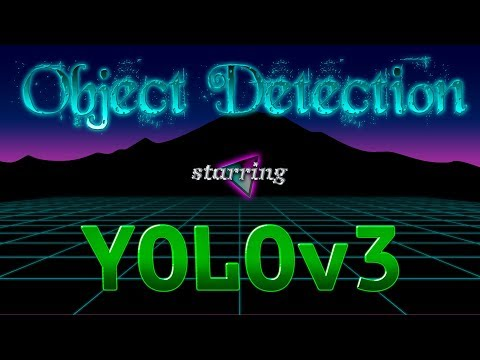

In [1]:
from IPython.display import YouTubeVideo
# a talk about IPython at Sage Days at U. Washington, Seattle.
# Video credit: William Stein.
YouTubeVideo('MPU2HistivI')

#### YOLO 및 유사 모델 구현 예제

* [YoloV3 Implemented in TensorFlow 2.0](https://github.com/zzh8829/yolov3-tf2)

* [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325)

* [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)

## 시맨틱 분할(Semantic Segmentation)

* 길, 자동차, 보행자, 건물 등 픽셀이 속한 객체에 따른 픽셀분류
    * 동일 부류의 객체는 서로 구별되지 않음. 
    * 아래 사진에서 자전거, 자동차 클래스 참조

<div align="center"><img src="images/ch14/homl14-33.png" width=650"/></div>

### 기본 아이디어

* CNN의 단점: 크기 2 이상의 보폭을 사용하는 합성곱/풀링 층으로 인해 위치 등 공간과 관련된 정보를 잃어버럼.
    * 예를 들어, 객체 존재정보는 알아내지만 잘못된 위치정보 계산 가능.

* 객체의 위치정보를 회복시킬 수 있어야 함.
    * 앞서 소개한 FCN 기법 활용

### 다운샘플링과 업샘플링

* 다운샘플링(downsampling)
    * 이미지 정보 일부를 상실하는 변환
    * 예제: 크기 2 이상의 보폭을 사용하는 합성곱/풀링 층 이미지 변환

* 업샘플링(upsampling)
    * 이미지 크기 증폭시키기
    * 다양한 방식으로 이미지 크기를 키울 수 있음.

### 업샘플링과 스킵연결

#### 업샘플링 예제

* 전치합성곱 층을 사용한 업샘플링: 
    * 이미지 늘리기: 0으로 채워진 행과 열 추가
    * 아래 그림 참조

<div align="center"><img src="images/ch14/homl14-34.png" width=350"/></div>

#### 스킵연결

* 업샘플링만으로는 제대로된 정보 회복 어려움.

* 스킵연결을 이용하여 풀링 과정에서 잃은 정보를 어느 정도 회복시켜주면 학습에 많은 도움 줌.

<div align="center"><img src="images/ch14/homl14-35.png" width=500"/></div>

### FCN 소개 및 활용 논문

#### Fully Convolutional Networks for Semantic Segmentation

* 출처: https://arxiv.org/pdf/1411.4038.pdf

<div align="center"><img src="images/ch14/homl14-30.png" width=550"/></div>

#### Learning Deconvolution Network for Semantic Segmentation

* 출처: https://arxiv.org/abs/1505.04366

* 다양한 용어 사용됨
    * upsampling = unpooling
    * convolution <=> deconvolution

<div align="center"><img src="images/ch14/homl14-32.png" width=800"/></div>

## 부록: 합성곱 신경망 시각화

* 합성곱 신경망의 각 층에서 이루어지는 작업을 시각화 가능
    * 참조: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)

* 얕은 층: 주로 직선 및 곡선, 색상 등의 낮은 수준의 특징이 활성화됨

* 깊은 층: 보다 복잡하고 포괄적인 개체 정보가 활성화됨.

<div align="center"><img src="images/ch14/homl14-24e.png" width="700"/></div>

<div align="center"><img src="images/ch14/homl14-24f.png" width="700"/></div>

<div align="center"><img src="images/ch14/homl14-24g.png" width="700"/></div>